# Minimization problems with varying input sizes

This notebook holds tests which estimate the required population sizes for efficient optimization of various functions at various input sizes

### Setup

In [1]:
import sys
CODEBASE = "./codebase"
if CODEBASE not in sys.path:
    sys.path.append(CODEBASE)

from cooperative_evolution_optimizers import GrayBoxOptimizer, BlackBoxOptimizer
from differential_evolution import DifferentialEvolution as DE
from evolution_strategies import EvolutionStrategies as ES
from particle_swarm_optimization import ParticleSwarmOptimization as PSO
from particle_swarm_optimization import *

from fitness_functions import FunctionFactory as FF

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from time import time
from copy import deepcopy as dc 

def plot_means_errs(xs, nparray):
    means = np.mean(nparray, axis=-1)
    errs = np.std(nparray, axis=-1)
    plt.errorbar(xs, means, yerr=errs, fmt="--o", capsize=5)
    
# other constants for testing
population_sizes = [10*(2**i) for i in range(0, 8)] # population sizes to test for optimality
run_count = 10 # number of times to run a given optimization setting

### Plotting Constants

In [2]:
labels = ['BBO', 'GBO']
colors = ["#111111", "#5b82a9"]
linestyles = ['-', ':']
handles = [Patch(color=color, label=label, linestyle=linestyle) 
           for color, label, linestyle in zip(colors, labels, linestyles)]

capsize = 5
markersize = 2
figsize = (8, 10)
metrics = ['generations', 'evaluations', 'runtimes']
metric_abbrevs = {'generations': 'gens',
                  'evaluations': 'evals',
                  'runtimes': 'times'}

---
# Sphere Fitness Function Tests 

In [56]:
sphere = FF.get_sphere()
sphere_input_space_lengths = list(range(1, 8+1))
lower_bound = -2
upper_bound = 3
goal_fitness = 1e-5
max_generations = 100

function_count = 3 # number of subfunctions that the GBO will optimize

## Differential Evolution Tests

### BBO Testing

In [ ]:
""" logging performance metrics """
sphere_de_bbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in sphere_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(sphere_input_space_lengths):
    # initialize information about functions and CC Optimizer
    function = sphere
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [DE]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                bbo = BlackBoxOptimizer(function = function,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not bbo.has_converged():
                    bbo.evolve()
                    
                generation_counts.append(bbo._generations)
                
                evaluation_counts.append(bbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if bbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                sphere_de_bbo_results[setting_index]['population_sizes'].append(population_size)
                sphere_de_bbo_results[setting_index]['generations'].append(generation_counts)
                sphere_de_bbo_results[setting_index]['evaluations'].append(evaluation_counts)
                sphere_de_bbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            bbo = BlackBoxOptimizer(function = function,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not bbo.has_converged():
                bbo.evolve()
                
            generation_counts.append(bbo._generations)
            evaluation_counts.append(bbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if bbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            sphere_de_bbo_results[setting_index]['population_sizes'].insert(0, population_size)
            sphere_de_bbo_results[setting_index]['generations'].insert(0, generation_counts)
            sphere_de_bbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            sphere_de_bbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

### GBO Testing

In [5]:
""" logging performance metrics """
sphere_de_gbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in sphere_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(sphere_input_space_lengths):
    # initialize information about functions and CC Optimizer
    functions = [sphere]*function_count
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [DE]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    input_spaces = train_partition
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                gbo = GrayBoxOptimizer(functions = functions,
                               input_spaces = input_spaces,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not gbo.has_converged():
                    gbo.evolve()
                    
                generation_counts.append(gbo._generations)
                evaluation_counts.append(gbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if gbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                sphere_de_gbo_results[setting_index]['population_sizes'].append(population_size)
                sphere_de_gbo_results[setting_index]['generations'].append(generation_counts)
                sphere_de_gbo_results[setting_index]['evaluations'].append(evaluation_counts)
                sphere_de_gbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            gbo = GrayBoxOptimizer(functions = functions,
                                   input_spaces = input_spaces,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not gbo.has_converged():
                gbo.evolve()
                
            generation_counts.append(gbo._generations)
            evaluation_counts.append(gbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if gbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            sphere_de_gbo_results[setting_index]['population_sizes'].insert(0, population_size)
            sphere_de_gbo_results[setting_index]['generations'].insert(0, generation_counts)
            sphere_de_gbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            sphere_de_gbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

### Plotting Results

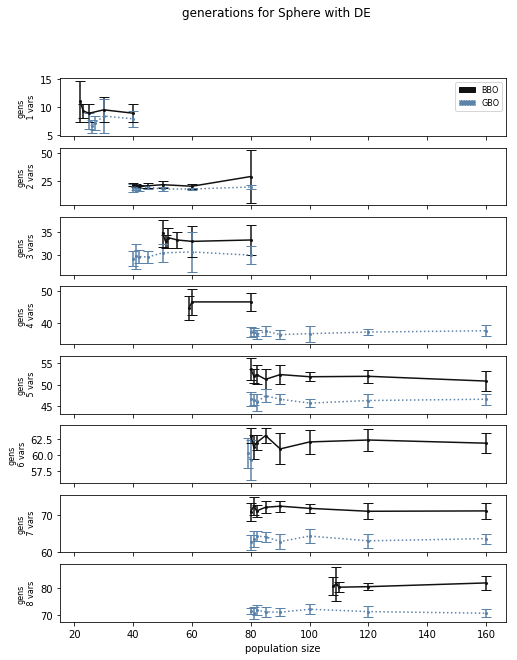

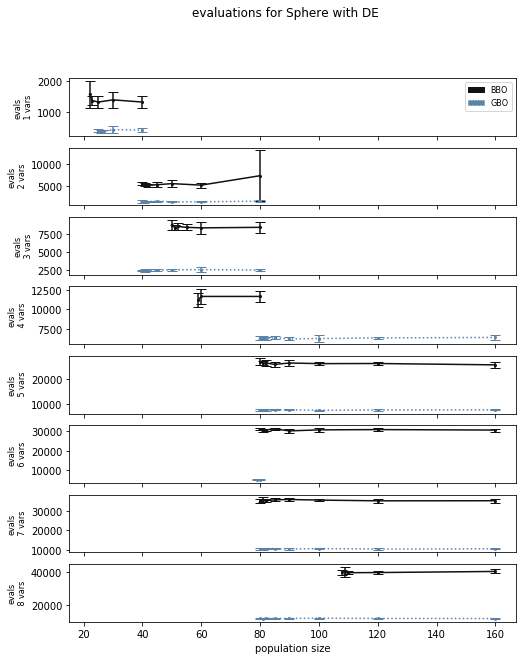

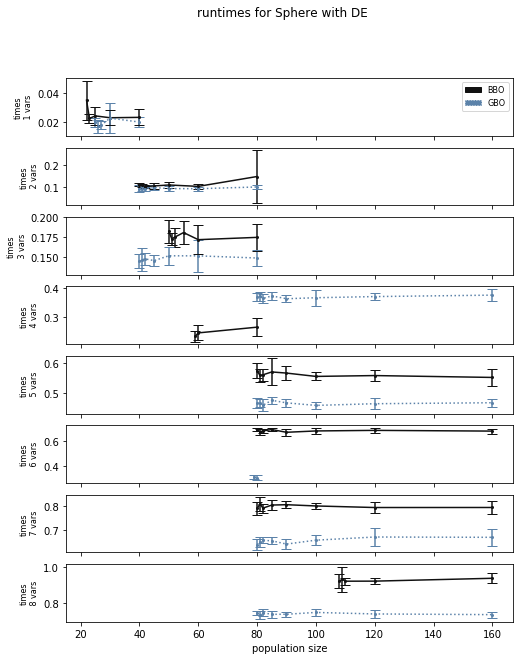

In [57]:
 """ plot results of experiments by input size """
result_lists = [sphere_de_bbo_results, sphere_de_gbo_results]

# plot all metrics against input size
for metric in metrics:
    # add labels and such to graph
    fig, axes = plt.subplots(len(sphere_input_space_lengths), sharex=True, sharey=False, figsize=figsize)
    fig.suptitle('{} for Sphere with DE'.format(metric))
    axes[0].legend(handles=handles, prop={'size': 8})
    axes[-1].set_xlabel('population size')

    for axis, setting_index, input_space_length in zip(axes, range(len(sphere_input_space_lengths)), sphere_input_space_lengths):
        axis.set_ylabel('{}\n {} vars'.format(metric_abbrevs[metric], input_space_length), fontsize=8)
        top = None

        for results, color, linestyle in zip(result_lists, colors, linestyles):
            means = [np.mean(vals) for vals in results[setting_index][metric]]
            errors = [np.std(vals) for vals in results[setting_index][metric]]

            axis.errorbar(x = results[setting_index]['population_sizes'],
                          y = means,
                          yerr = errors,
                          fmt = "--o",
                          capsize = capsize,
                          markersize = markersize,
                          color = color,
                          linestyle = linestyle)
            
    fig.savefig('plots/input_DE_sphere_{}.pdf'.format(metric))

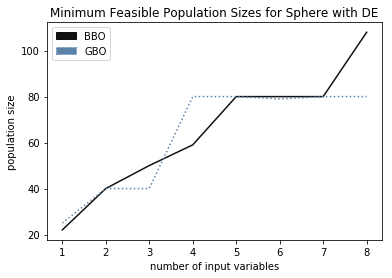

In [58]:
plt.figure()
plt.title("Minimum Feasible Population Sizes for Sphere with DE")
plt.xticks(sphere_input_space_lengths)
plt.xlabel('number of input variables')
plt.ylabel('population size')
plt.legend(handles = handles)

for results, color, linestyle in zip(result_lists, colors, linestyles):
    efficient_sizes = []
    for r in results:
        if r['population_sizes'] != []:
            efficient_sizes.append(r['population_sizes'][0])
        else:
            break
    
    plt.plot(sphere_input_space_lengths[:len(efficient_sizes)],
            efficient_sizes,
            color = color,
            linestyle = linestyle)
    
plt.savefig('plots/input_DE_sphere_best.pdf')

## Particle Swarm Optimization Tests

### BBO Testing

In [8]:
""" logging performance metrics """
bbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in sphere_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(sphere_input_space_lengths):
    # initialize information about functions and CC Optimizer
    function = sphere
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [PSO]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                bbo = BlackBoxOptimizer(function = function,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not bbo.has_converged():
                    bbo.evolve()
                    
                generation_counts.append(bbo._generations)
                evaluation_counts.append(bbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if bbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                bbo_results[setting_index]['population_sizes'].append(population_size)
                bbo_results[setting_index]['generations'].append(generation_counts)
                bbo_results[setting_index]['evaluations'].append(evaluation_counts)
                bbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            bbo = BlackBoxOptimizer(function = function,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not bbo.has_converged():
                bbo.evolve()
                
            generation_counts.append(bbo._generations)
            evaluation_counts.append(bbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if bbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            bbo_results[setting_index]['population_sizes'].insert(0, population_size)
            bbo_results[setting_index]['generations'].insert(0, generation_counts)
            bbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            bbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

Test never passed for input_space_length = 6


### GBO Testing

In [9]:
""" logging performance metrics """
gbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in sphere_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(sphere_input_space_lengths):
    # initialize information about functions and CC Optimizer
    functions = [sphere]*function_count
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [PSO]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    input_spaces = train_partition
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                gbo = GrayBoxOptimizer(functions = functions,
                               input_spaces = input_spaces,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not gbo.has_converged():
                    gbo.evolve()
                    
                generation_counts.append(gbo._generations)
                evaluation_counts.append(gbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if gbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                gbo_results[setting_index]['population_sizes'].append(population_size)
                gbo_results[setting_index]['generations'].append(generation_counts)
                gbo_results[setting_index]['evaluations'].append(evaluation_counts)
                gbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            gbo = GrayBoxOptimizer(functions = functions,
                                   input_spaces = input_spaces,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not gbo.has_converged():
                gbo.evolve()
                
            generation_counts.append(gbo._generations)
            evaluation_counts.append(gbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if gbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            gbo_results[setting_index]['population_sizes'].insert(0, population_size)
            gbo_results[setting_index]['generations'].insert(0, generation_counts)
            gbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            gbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

Test never passed for input_space_length = 6


### Plotting Results

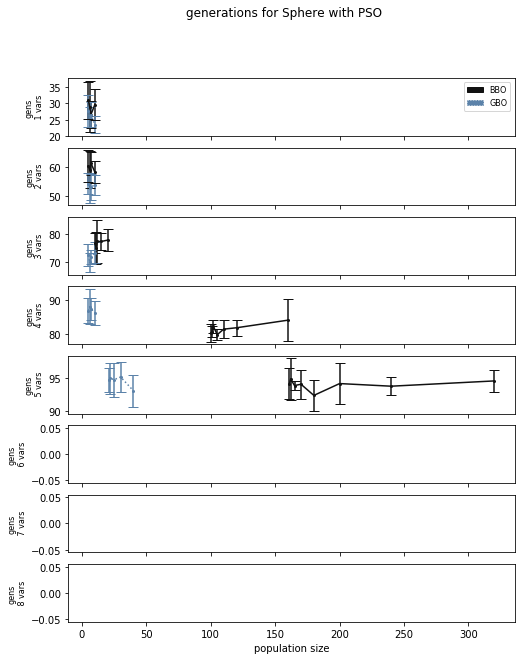

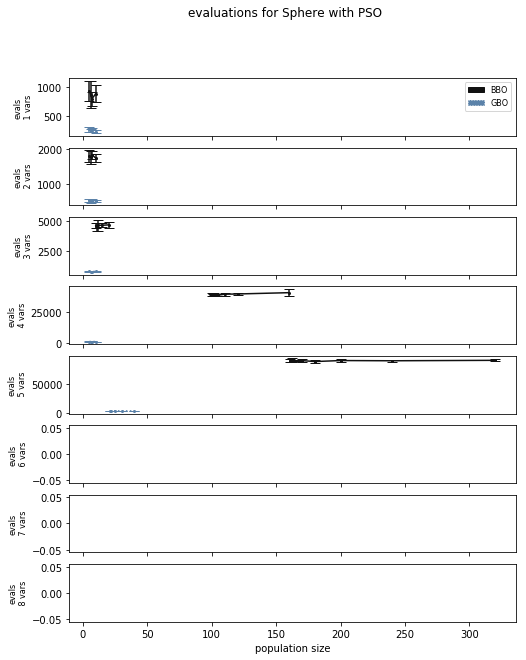

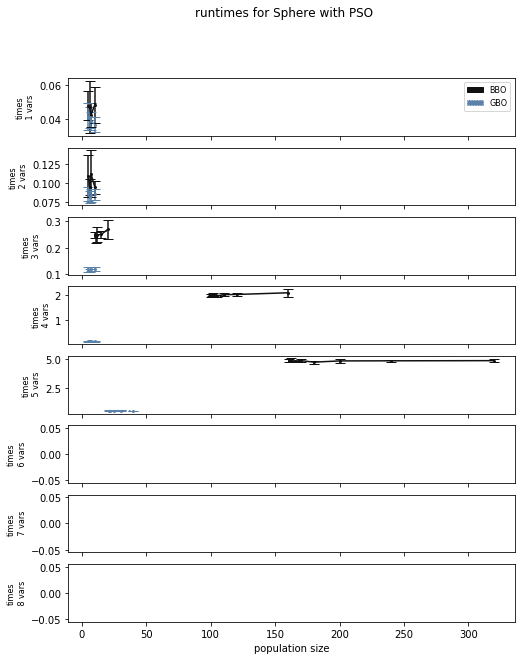

In [59]:
 """ plot results of experiments by input size """
result_lists = [bbo_results, gbo_results]

# plot all metrics against input size
for metric in metrics:
    # add labels and such to graph
    fig, axes = plt.subplots(len(sphere_input_space_lengths), sharex=True, sharey=False, figsize=figsize)
    fig.suptitle('{} for Sphere with PSO'.format(metric))
    axes[0].legend(handles=handles, prop={'size': 8})
    axes[-1].set_xlabel('population size')

    for axis, setting_index, input_space_length in zip(axes, range(len(sphere_input_space_lengths)), sphere_input_space_lengths):
        axis.set_ylabel('{}\n {} vars'.format(metric_abbrevs[metric], input_space_length), fontsize=8)

        for results, color, linestyle in zip(result_lists, colors, linestyles):
            means = [np.mean(vals) for vals in results[setting_index][metric]]
            errors = [np.std(vals) for vals in results[setting_index][metric]]

            axis.errorbar(x = results[setting_index]['population_sizes'],
                          y = means,
                          yerr = errors,
                          fmt = "--o",
                          capsize = capsize,
                          markersize = markersize,
                          color = color,
                          linestyle = linestyle)
            
    fig.savefig('plots/input_PSO_sphere_{}.pdf'.format(metric))

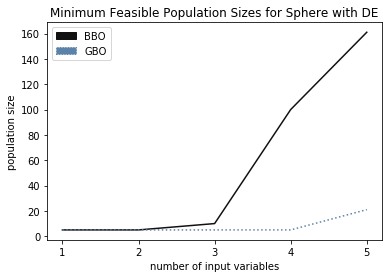

In [60]:
plt.figure()
plt.title("Minimum Feasible Population Sizes for Sphere with DE")
plt.xticks(sphere_input_space_lengths)
plt.xlabel('number of input variables')
plt.ylabel('population size')
plt.legend(handles = handles)

for results, color, linestyle in zip(result_lists, colors, linestyles):
    efficient_sizes = []
    for r in results:
        if r['population_sizes'] != []:
            efficient_sizes.append(r['population_sizes'][0])
        else:
            break
    
    plt.plot(sphere_input_space_lengths[:len(efficient_sizes)],
            efficient_sizes,
            color = color,
            linestyle = linestyle)
    
plt.savefig('plots/input_PSO_sphere_best.pdf')

-----
# Rosenbrock Fitness Function Tests

In [62]:
rosenbrock = FF.get_rosenbrock()
rosenbrock_input_space_lengths = list(range(1, 5+1))
lower_bound = -2
upper_bound = 3
goal_fitness = 1e-4
max_generations = 250

run_count = 10 # number of times to run a given optimization setting
function_count = 3 # number of subfunctions that the GBO will optimize

## Differential Evolution Tests

### BBO Testing

In [13]:
""" logging performance metrics """
rosenbrock_de_bbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in rosenbrock_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(rosenbrock_input_space_lengths):
    # initialize information about functions and CC Optimizer
    function = rosenbrock
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [DE]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                bbo = BlackBoxOptimizer(function = function,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not bbo.has_converged():
                    bbo.evolve()
                    
                generation_counts.append(bbo._generations)
                evaluation_counts.append(bbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if bbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                rosenbrock_de_bbo_results[setting_index]['population_sizes'].append(population_size)
                rosenbrock_de_bbo_results[setting_index]['generations'].append(generation_counts)
                rosenbrock_de_bbo_results[setting_index]['evaluations'].append(evaluation_counts)
                rosenbrock_de_bbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            bbo = BlackBoxOptimizer(function = function,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not bbo.has_converged():
                bbo.evolve()
                
            generation_counts.append(bbo._generations)
            evaluation_counts.append(bbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if bbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            rosenbrock_de_bbo_results[setting_index]['population_sizes'].insert(0, population_size)
            rosenbrock_de_bbo_results[setting_index]['generations'].insert(0, generation_counts)
            rosenbrock_de_bbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            rosenbrock_de_bbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

Test never passed for input_space_length = 1


### GBO Testing

In [14]:
""" logging performance metrics """
rosenbrock_de_gbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in rosenbrock_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(rosenbrock_input_space_lengths):
    # initialize information about functions and CC Optimizer
    functions = [rosenbrock]*function_count
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [DE]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    input_spaces = train_partition
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                gbo = GrayBoxOptimizer(functions = functions,
                               input_spaces = input_spaces,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not gbo.has_converged():
                    gbo.evolve()
                    
                generation_counts.append(gbo._generations)
                evaluation_counts.append(gbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if gbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                rosenbrock_de_gbo_results[setting_index]['population_sizes'].append(population_size)
                rosenbrock_de_gbo_results[setting_index]['generations'].append(generation_counts)
                rosenbrock_de_gbo_results[setting_index]['evaluations'].append(evaluation_counts)
                rosenbrock_de_gbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            gbo = GrayBoxOptimizer(functions = functions,
                                   input_spaces = input_spaces,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not gbo.has_converged():
                gbo.evolve()
                
            generation_counts.append(gbo._generations)
            evaluation_counts.append(gbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if gbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            rosenbrock_de_gbo_results[setting_index]['population_sizes'].insert(0, population_size)
            rosenbrock_de_gbo_results[setting_index]['generations'].insert(0, generation_counts)
            rosenbrock_de_gbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            rosenbrock_de_gbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

Test never passed for input_space_length = 4


### Plotting Results

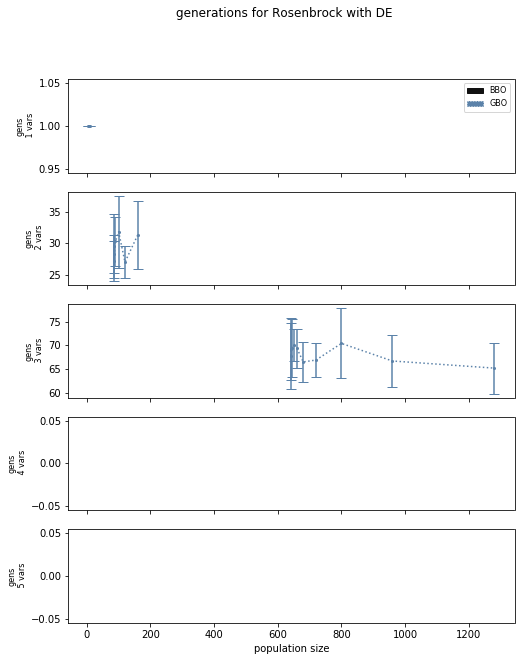

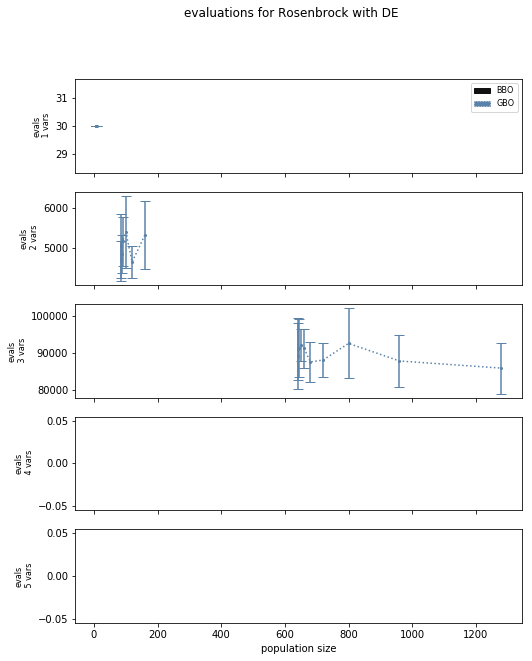

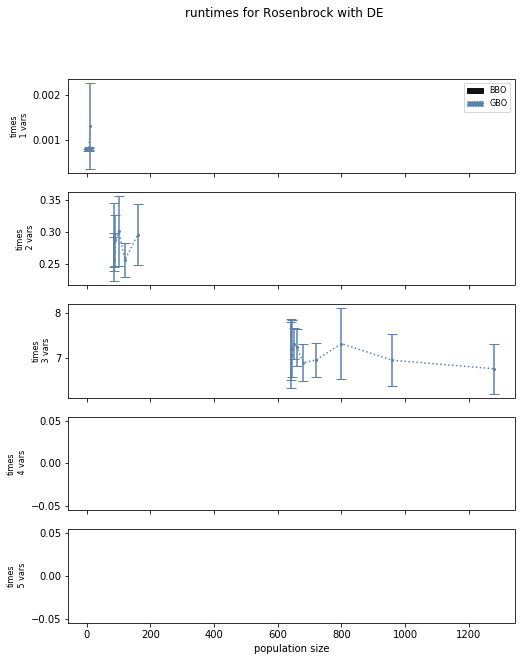

In [63]:
 """ plot results of experiments by input size """
result_lists = [rosenbrock_de_bbo_results, rosenbrock_de_gbo_results]

# plot all metrics against input size
for metric in metrics:
    # add labels and such to graph
    fig, axes = plt.subplots(len(rosenbrock_input_space_lengths), sharex=True, sharey=False, figsize=figsize)
    fig.suptitle('{} for Rosenbrock with DE'.format(metric))
    axes[0].legend(handles=handles, prop={'size': 8})
    axes[-1].set_xlabel('population size')

    for axis, setting_index, input_space_length in zip(axes, range(len(rosenbrock_input_space_lengths)), rosenbrock_input_space_lengths):
        axis.set_ylabel('{}\n {} vars'.format(metric_abbrevs[metric], input_space_length), fontsize=8)

        for results, color, linestyle in zip(result_lists, colors, linestyles):
            means = [np.mean(vals) for vals in results[setting_index][metric]]
            errors = [np.std(vals) for vals in results[setting_index][metric]]

            axis.errorbar(x = results[setting_index]['population_sizes'],
                          y = means,
                          yerr = errors,
                          fmt = "--o",
                          capsize = capsize,
                          markersize = markersize,
                          color = color,
                          linestyle = linestyle)
            
    fig.savefig('plots/input_DE_rosenbrock_{}.pdf'.format(metric))

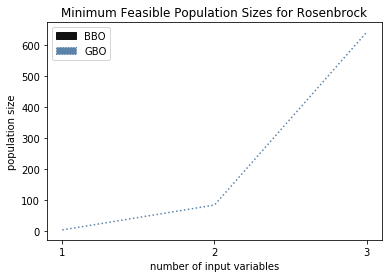

In [64]:
plt.figure()
plt.title("Minimum Feasible Population Sizes for Rosenbrock")
plt.xticks(rosenbrock_input_space_lengths)
plt.xlabel('number of input variables')
plt.ylabel('population size')
plt.legend(handles = handles)

for results, color, linestyle in zip(result_lists, colors, linestyles):
    efficient_sizes = []
    for r in results:
        if r['population_sizes'] != []:
            efficient_sizes.append(r['population_sizes'][0])
        else:
            break
    
    plt.plot(rosenbrock_input_space_lengths[:len(efficient_sizes)],
            efficient_sizes,
color = color,
            linestyle = linestyle)
    
plt.savefig('plots/input_DE_rosenbrock_best.pdf')

## Particle Swarm Optimization Tests

### BBO Testing

In [17]:
""" logging performance metrics """
rosenbrock_pso_bbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in rosenbrock_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(rosenbrock_input_space_lengths):
    # initialize information about functions and CC Optimizer
    function = rosenbrock
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [PSO]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                bbo = BlackBoxOptimizer(function = function,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not bbo.has_converged():
                    bbo.evolve()
                    
                generation_counts.append(bbo._generations)
                evaluation_counts.append(bbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if bbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                rosenbrock_pso_bbo_results[setting_index]['population_sizes'].append(population_size)
                rosenbrock_pso_bbo_results[setting_index]['generations'].append(generation_counts)
                rosenbrock_pso_bbo_results[setting_index]['evaluations'].append(evaluation_counts)
                rosenbrock_pso_bbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            bbo = BlackBoxOptimizer(function = function,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not bbo.has_converged():
                bbo.evolve()
                
            generation_counts.append(bbo._generations)
            evaluation_counts.append(bbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if bbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            rosenbrock_pso_bbo_results[setting_index]['population_sizes'].insert(0, population_size)
            rosenbrock_pso_bbo_results[setting_index]['generations'].insert(0, generation_counts)
            rosenbrock_pso_bbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            rosenbrock_pso_bbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

Test never passed for input_space_length = 1


### GBO Testing

In [18]:
""" logging performance metrics """
rosenbrock_pso_gbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in rosenbrock_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(rosenbrock_input_space_lengths):
    # initialize information about functions and CC Optimizer
    functions = [rosenbrock]*function_count
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [PSO]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    input_spaces = train_partition
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                gbo = GrayBoxOptimizer(functions = functions,
                               input_spaces = input_spaces,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not gbo.has_converged():
                    gbo.evolve()
                    
                generation_counts.append(gbo._generations)
                evaluation_counts.append(gbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if gbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                rosenbrock_pso_gbo_results[setting_index]['population_sizes'].append(population_size)
                rosenbrock_pso_gbo_results[setting_index]['generations'].append(generation_counts)
                rosenbrock_pso_gbo_results[setting_index]['evaluations'].append(evaluation_counts)
                rosenbrock_pso_gbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            gbo = GrayBoxOptimizer(functions = functions,
                                   input_spaces = input_spaces,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not gbo.has_converged():
                gbo.evolve()
                
            generation_counts.append(gbo._generations)
            evaluation_counts.append(gbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if gbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            rosenbrock_pso_gbo_results[setting_index]['population_sizes'].insert(0, population_size)
            rosenbrock_pso_gbo_results[setting_index]['generations'].insert(0, generation_counts)
            rosenbrock_pso_gbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            rosenbrock_pso_gbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

Test never passed for input_space_length = 3


### Plotting Results

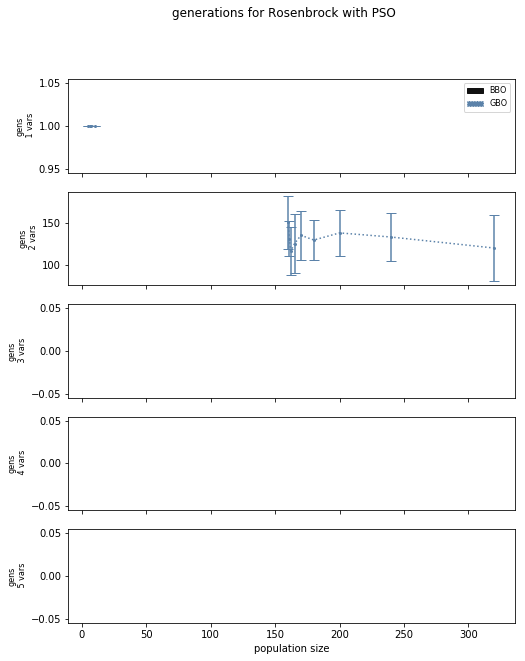

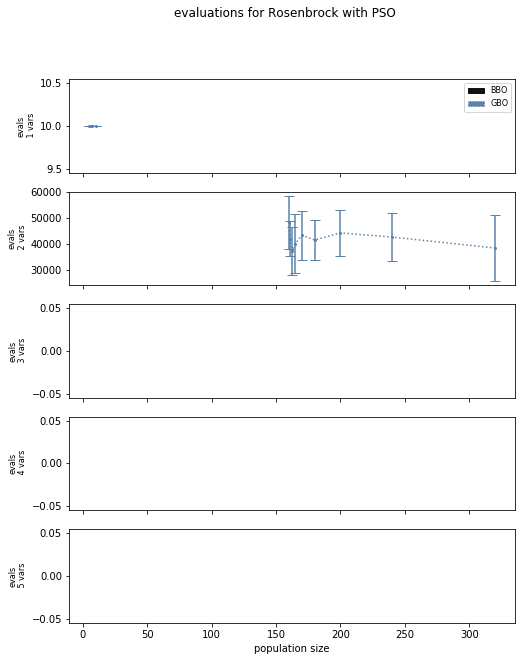

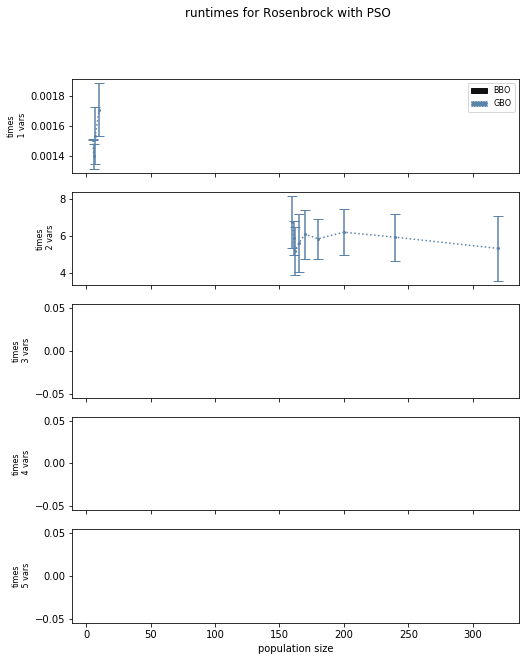

In [65]:
 """ plot results of experiments by input size """
result_lists = [rosenbrock_pso_bbo_results, rosenbrock_pso_gbo_results]

# plot all metrics against input size
for metric in metrics:
    # add labels and such to graph
    fig, axes = plt.subplots(len(rosenbrock_input_space_lengths), sharex=True, sharey=False, figsize=figsize)
    fig.suptitle('{} for Rosenbrock with PSO'.format(metric))
    axes[0].legend(handles=handles, prop={'size': 8})
    axes[-1].set_xlabel('population size')

    for axis, setting_index, input_space_length in zip(axes, range(len(rosenbrock_input_space_lengths)), rosenbrock_input_space_lengths):
        axis.set_ylabel('{}\n {} vars'.format(metric_abbrevs[metric], input_space_length), fontsize=8)

        for results, color, linestyle in zip(result_lists, colors, linestyles):
            means = [np.mean(vals) for vals in results[setting_index][metric]]
            errors = [np.std(vals) for vals in results[setting_index][metric]]

            axis.errorbar(x = results[setting_index]['population_sizes'],
                          y = means,
                          yerr = errors,
                          fmt = "--o",
                          capsize = capsize,
                          markersize = markersize,
                          color = color,
                          linestyle = linestyle)
            
    fig.savefig('plots/input_PSO_rosenbrock_{}.pdf'.format(metric))

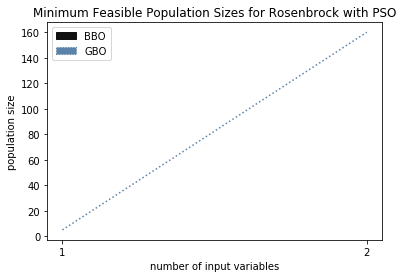

In [66]:
plt.figure()
plt.title("Minimum Feasible Population Sizes for Rosenbrock with PSO")
plt.xticks(rosenbrock_input_space_lengths)
plt.xlabel('number of input variables')
plt.ylabel('population size')
plt.legend(handles = handles)

for results, color, linestyle in zip(result_lists, colors, linestyles):
    efficient_sizes = []
    for r in results:
        if r['population_sizes'] != []:
            efficient_sizes.append(r['population_sizes'][0])
        else:
            break
    
    plt.plot(rosenbrock_input_space_lengths[:len(efficient_sizes)],
            efficient_sizes,
            color = color,
            linestyle = linestyle)

plt.savefig('plots/input_PSO_rosenbrock_best.pdf')

-----
# SoREB Fitness Function Tests

In [67]:
soreb = FF.get_soreb(k=2)
soreb_input_space_lengths = list(range(2, 10+1, 2))
lower_bound = -2
upper_bound = 3
goal_fitness = 1e-3
max_generations = 500

run_count = 10 # number of times to run a given optimization setting
function_count = 3 # number of subfunctions that the GBO will optimize

## Differential Evolution Tests

### BBO Testing

In [22]:
""" logging performance metrics """
soreb_de_bbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in soreb_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(soreb_input_space_lengths):
    # initialize information about functions and CC Optimizer
    function = soreb
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [DE]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                bbo = BlackBoxOptimizer(function = function,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not bbo.has_converged():
                    bbo.evolve()
                    
                generation_counts.append(bbo._generations)
                evaluation_counts.append(bbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if bbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                soreb_de_bbo_results[setting_index]['population_sizes'].append(population_size)
                soreb_de_bbo_results[setting_index]['generations'].append(generation_counts)
                soreb_de_bbo_results[setting_index]['evaluations'].append(evaluation_counts)
                soreb_de_bbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            bbo = BlackBoxOptimizer(function = function,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not bbo.has_converged():
                bbo.evolve()
                
            generation_counts.append(bbo._generations)
            evaluation_counts.append(bbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if bbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            soreb_de_bbo_results[setting_index]['population_sizes'].insert(0, population_size)
            soreb_de_bbo_results[setting_index]['generations'].insert(0, generation_counts)
            soreb_de_bbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            soreb_de_bbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

Test never passed for input_space_length = 8


### GBO Testing

In [23]:
""" logging performance metrics """
soreb_de_gbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in soreb_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(soreb_input_space_lengths):
    # initialize information about functions and CC Optimizer
    functions = [soreb]*function_count
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [DE]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    input_spaces = train_partition
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                gbo = GrayBoxOptimizer(functions = functions,
                               input_spaces = input_spaces,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not gbo.has_converged():
                    gbo.evolve()
                    
                generation_counts.append(gbo._generations)
                evaluation_counts.append(gbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if gbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                soreb_de_gbo_results[setting_index]['population_sizes'].append(population_size)
                soreb_de_gbo_results[setting_index]['generations'].append(generation_counts)
                soreb_de_gbo_results[setting_index]['evaluations'].append(evaluation_counts)
                soreb_de_gbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            gbo = GrayBoxOptimizer(functions = functions,
                                   input_spaces = input_spaces,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not gbo.has_converged():
                gbo.evolve()
                
            generation_counts.append(gbo._generations)
            evaluation_counts.append(gbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if gbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            soreb_de_gbo_results[setting_index]['population_sizes'].insert(0, population_size)
            soreb_de_gbo_results[setting_index]['generations'].insert(0, generation_counts)
            soreb_de_gbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            soreb_de_gbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

Test never passed for input_space_length = 8


### Plotting Results

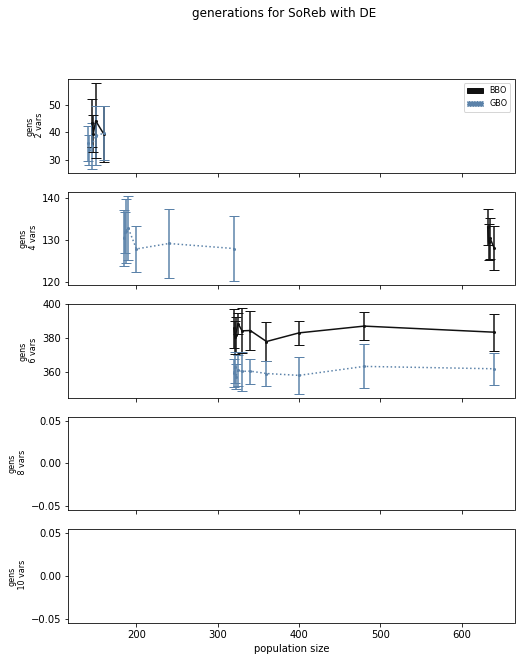

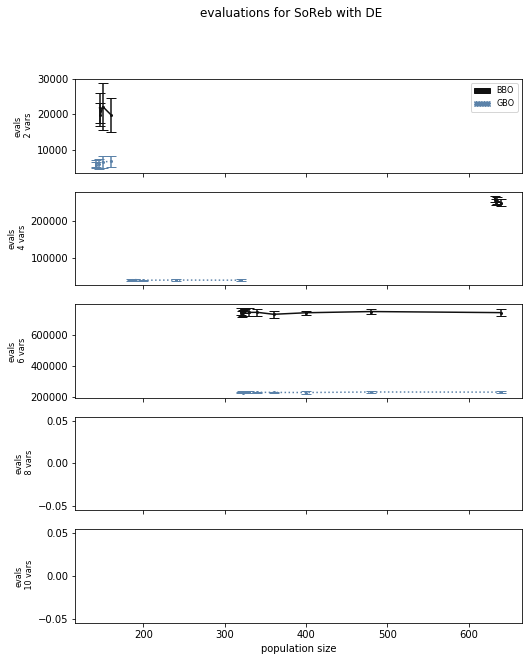

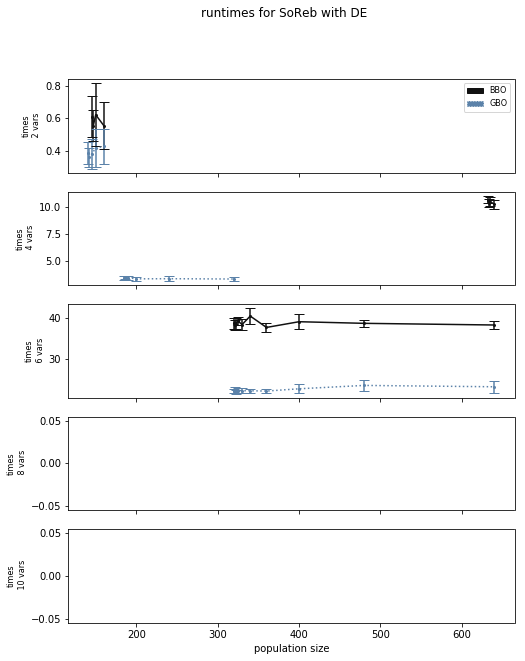

In [68]:
 """ plot results of experiments by input size """
result_lists = [soreb_de_bbo_results, soreb_de_gbo_results]

# plot all metrics against input size
for metric in metrics:
    # add labels and such to graph
    fig, axes = plt.subplots(len(soreb_input_space_lengths), sharex=True, sharey=False, figsize=figsize)
    fig.suptitle('{} for SoReb with DE'.format(metric))
    axes[0].legend(handles=handles, prop={'size': 8})
    axes[-1].set_xlabel('population size')

    for axis, setting_index, input_space_length in zip(axes, range(len(soreb_input_space_lengths)), soreb_input_space_lengths):
        axis.set_ylabel('{}\n {} vars'.format(metric_abbrevs[metric], input_space_length), fontsize=8)

        for results, color, linestyle in zip(result_lists, colors, linestyles):
            means = [np.mean(vals) for vals in results[setting_index][metric]]
            errors = [np.std(vals) for vals in results[setting_index][metric]]

            axis.errorbar(x = results[setting_index]['population_sizes'],
                          y = means,
                          yerr = errors,
                          fmt = "--o",
                          capsize = capsize,
                          markersize = markersize,
                          color = color,
                          linestyle = linestyle)
            
    fig.savefig('plots/input_DE_soreb_{}.pdf'.format(metric))

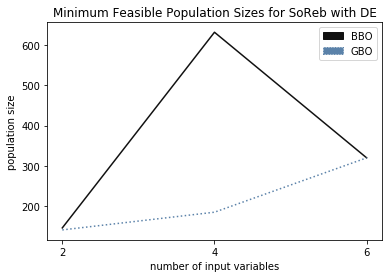

In [69]:
plt.figure()
plt.title("Minimum Feasible Population Sizes for SoReb with DE")
plt.xticks(soreb_input_space_lengths)
plt.xlabel('number of input variables')
plt.ylabel('population size')
plt.legend(handles = handles)

for results, color, linestyle in zip(result_lists, colors, linestyles):
    efficient_sizes = []
    for r in results:
        if r['population_sizes'] != []:
            efficient_sizes.append(r['population_sizes'][0])
        else:
            break
    
    plt.plot(soreb_input_space_lengths[:len(efficient_sizes)],
            efficient_sizes,
            color = color,
            linestyle = linestyle)
    
plt.savefig('plots/input_DE_soreb_best.pdf')

## Particle Swarm Optimization Tests

### BBO Testing

In [26]:
""" logging performance metrics """
soreb_pso_bbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in soreb_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(soreb_input_space_lengths):
    # initialize information about functions and CC Optimizer
    function = soreb
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [PSO]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                bbo = BlackBoxOptimizer(function = function,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not bbo.has_converged():
                    bbo.evolve()
                    
                generation_counts.append(bbo._generations)
                evaluation_counts.append(bbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if bbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                soreb_pso_bbo_results[setting_index]['population_sizes'].append(population_size)
                soreb_pso_bbo_results[setting_index]['generations'].append(generation_counts)
                soreb_pso_bbo_results[setting_index]['evaluations'].append(evaluation_counts)
                soreb_pso_bbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            bbo = BlackBoxOptimizer(function = function,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not bbo.has_converged():
                bbo.evolve()
                
            generation_counts.append(bbo._generations)
            evaluation_counts.append(bbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if bbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            soreb_pso_bbo_results[setting_index]['population_sizes'].insert(0, population_size)
            soreb_pso_bbo_results[setting_index]['generations'].insert(0, generation_counts)
            soreb_pso_bbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            soreb_pso_bbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

Test never passed for input_space_length = 4


### GBO Testing

In [27]:
""" logging performance metrics """
soreb_pso_gbo_results = [{'population_sizes': [], 'generations': [], 'evaluations': [], 'runtimes': []}
          for j in soreb_input_space_lengths]


""" testing loop """
for setting_index, input_space_length in enumerate(soreb_input_space_lengths):
    # initialize information about functions and CC Optimizer
    functions = [soreb]*function_count
    lower_bounds = [lower_bound]*function_count*input_space_length
    upper_bounds = [upper_bound]*function_count*input_space_length
    genetic_algorithms = [PSO]*function_count
    train_partition = [list(range(i*input_space_length, (i+1)*input_space_length)) for i in range(function_count)]
    input_spaces = train_partition
    
    # run the experiment with the given settings some number of times
    # if the experiment doesn't succeed after enough tries, try larger populations
    # finish if 10/10 tests succeeded
    last_size = -1
        
    for population_size in population_sizes:
            # run test some number of times to see if it converges enough
            generation_counts = []
            evaluation_counts = []
            runtimes = []
            arguments = [{'population_size': population_size} for _ in range(function_count)]
            
            for run_index in range(run_count):
                gbo = GrayBoxOptimizer(functions = functions,
                               input_spaces = input_spaces,
                               train_partition = train_partition,
                               lower_bounds = lower_bounds,
                               upper_bounds = upper_bounds,
                               genetic_algorithms = genetic_algorithms,
                               genetic_algorithm_arguments = arguments,
                               max_generations = max_generations,
                               goal_fitness = goal_fitness)

                # run until convergence, timeout, etc.
                start_time = time()
                
                while not gbo.has_converged():
                    gbo.evolve()
                    
                generation_counts.append(gbo._generations)
                evaluation_counts.append(gbo.get_evaluations())
                runtimes.append(time()-start_time)
                    
                # see if we've converged early enough, and if so, begin testing in reverse
                if gbo._generations >= max_generations: break
            
            # if we succeeded in testing, proceed
            if run_index == run_count-1:
                last_size = population_size
                soreb_pso_gbo_results[setting_index]['population_sizes'].append(population_size)
                soreb_pso_gbo_results[setting_index]['generations'].append(generation_counts)
                soreb_pso_gbo_results[setting_index]['evaluations'].append(evaluation_counts)
                soreb_pso_gbo_results[setting_index]['runtimes'].append(runtimes)
                break
    
    if last_size == -1:
        print("Test never passed for input_space_length = {}".format(input_space_length))
        break
    
    # now that we've found a size that works, try to make it lower
    lower_size = last_size/2
    
    while last_size != lower_size:
        population_size = (last_size+lower_size)//2
        generation_counts = []
        evaluation_counts = []
        runtimes = []
        
        for run_index in range(run_count):
            gbo = GrayBoxOptimizer(functions = functions,
                                   input_spaces = input_spaces,
                                   train_partition = train_partition,
                                   lower_bounds = lower_bounds,
                                   upper_bounds = upper_bounds,
                                   genetic_algorithms = genetic_algorithms,
                                   genetic_algorithm_arguments = arguments,
                                   max_generations = max_generations,
                                   goal_fitness = goal_fitness)
        
            # run until convergence, timeout, etc.
            start_time = time()

            while not gbo.has_converged():
                gbo.evolve()
                
            generation_counts.append(gbo._generations)
            evaluation_counts.append(gbo.get_evaluations())
            runtimes.append(time()-start_time)    
            
            if gbo._generations >= max_generations: break
                
        # see if we've reached the convergence condition enough, and log accordingly 
        # add stuff to the beginnings to plot stuff in order
        if run_index == run_count-1:
            last_size = population_size
            soreb_pso_gbo_results[setting_index]['population_sizes'].insert(0, population_size)
            soreb_pso_gbo_results[setting_index]['generations'].insert(0, generation_counts)
            soreb_pso_gbo_results[setting_index]['evaluations'].insert(0, evaluation_counts)
            soreb_pso_gbo_results[setting_index]['runtimes'].insert(0, runtimes)
        else:
            lower_size = population_size           

Test never passed for input_space_length = 4


### Plotting Results

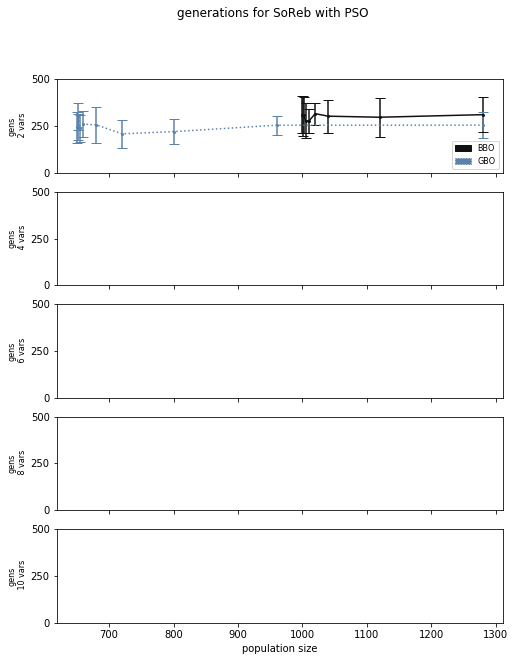

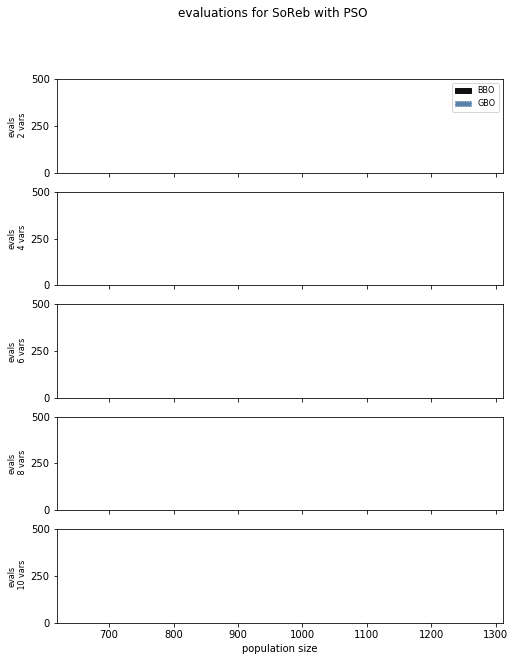

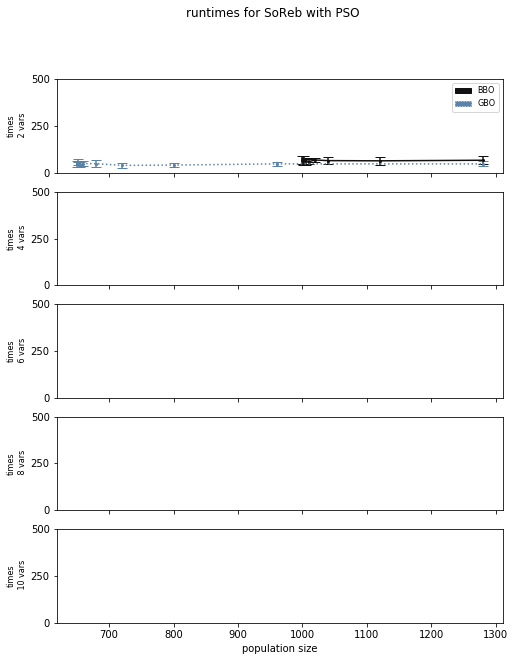

In [70]:
 """ plot results of experiments by input size """
result_lists = [soreb_pso_bbo_results, soreb_pso_gbo_results]

for metric in metrics:
    # add labels and such to graph
    fig, axes = plt.subplots(len(soreb_input_space_lengths), sharex=True, sharey=False, figsize=figsize)
    fig.suptitle('{} for SoReb with PSO'.format(metric))
    axes[0].legend(handles=handles, prop={'size': 8})
    axes[-1].set_xlabel('population size')

    for axis, setting_index, input_space_length in zip(axes, range(len(soreb_input_space_lengths)), soreb_input_space_lengths):
        axis.set_ylim(0, max_generations)
        axis.set_ylabel('{}\n {} vars'.format(metric_abbrevs[metric], input_space_length), fontsize=8)
        axis.set_yticks(range(0, max_generations+1, max_generations//2))

        for results, color, linestyle in zip(result_lists, colors, linestyles):
            means = [np.mean(vals) for vals in results[setting_index][metric]]
            errors = [np.std(vals) for vals in results[setting_index][metric]]

            axis.errorbar(x = results[setting_index]['population_sizes'],
                          y = means,
                          yerr = errors,
                          fmt = "--o",
                          capsize = capsize,
                          markersize = markersize,
                          color = color,
                          linestyle = linestyle)

    fig.savefig('plots/input_PSO_soreb_{}.pdf'.format(metric))
    

[2]


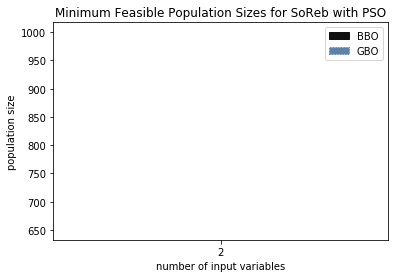

In [71]:
plt.figure()
plt.title("Minimum Feasible Population Sizes for SoReb with PSO")
plt.xticks(soreb_input_space_lengths)
plt.xlabel('number of input variables')
plt.ylabel('population size')
plt.legend(handles = handles)

for results, color, linestyle in zip(result_lists, colors, linestyles):
    efficient_sizes = []
    for r in results:
        if r['population_sizes'] != []:
            efficient_sizes.append(r['population_sizes'][0])
        else:
            break
    
    plt.plot(soreb_input_space_lengths[:len(efficient_sizes)],
            efficient_sizes,
            color = color,
            linestyle = linestyle)
    
print(soreb_input_space_lengths[:len(efficient_sizes)])

plt.savefig('plots/input_PSO_soreb_best.pdf')